https://arxiv.org/pdf/2307.00908.pdf
    - Modified Layerwise Learning As the name suggests, this strategy involves training the circuit layer by layer such
    that only a small set of parameters are optimized in a single update [303]. Initially, only a small circuit with few start
    layers is chosen such that all parameters are set to 0. This circuit is optimized by running it for a few epochs. The
    parameters are now frozen and a new set of layers is added. Now, the new layers’ parameters are optimized with the
    previous layers’ frozen parameters until no more improvement is obtained in the cost function or until the desired
    depth is reached. Then, the circuit depth is fixed and a larger set of the parameters is trained again. This strategy can
    help avoid the barren plateau due to the small number of layers and also maintains a favorable signal-to-noise ratio.
    [231, 303].
    - However in [236], training using
    single data per update led to slow convergence with volatile validation loss per epoch which was avoided by increasing
    the batch size to 64.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from discopy.grammar import Word
from discopy.rigid import Cup, Id, Ty
import torch
import random
from sentence_transformers import SentenceTransformer
from lambeq import LossFunction, PennyLaneModel, PytorchTrainer, QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss, Dataset, AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz, BobcatParser
from lambeq.pregroups import remove_cups
import jax as jnp


from jax import numpy as jnp
import os
import joblib

c:\Users\henry\Desktop\MastersProject\quantum_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_and_preprocess_data():
    df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')
    # assign column names to the dataframe
    df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']
    # group the data by the three sentence columns and calculate the mean and standard deviation of the score column
    grouped_data = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()
    # flatten the multi-level column names of the grouped data
    grouped_data.columns = [' '.join(col).strip() for col in grouped_data.columns.values]
    # rename the mean and std columns to 'score' and 'range' respectively
    grouped_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
    grouped_data['score'] = grouped_data['score']/grouped_data['score'].max()
    unique_word_list = []
    for ind, row in grouped_data.iterrows():
        for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
            unique_word_list.append(i)
    unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements
    grouped_data.to_csv("Data/AveragedLargerSadrKartTransative.txt")
    # Create an instance of MinMaxScaler
    #ERROR: SCALING STOPPED ALL CONVERGENCES!
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    # Rescale the 'score' column
    #grouped_data['score'] = scaler.fit_transform(grouped_data[['score']])
    return grouped_data, unique_word_list
dataset, unique_word_list = read_and_preprocess_data()

In [3]:
def retrive_nth_rows_sentences(data, row1, row2=None):
    if not row2:
        row2=row1
    sentence1 = data['subject'+str(1)][row1] + " " + data['verb'+str(1)][row1]  + " " + data['object'+str(1)][row1] 
    sentence2 = data['subject'+str(2)][row2] + " " + data['verb'+str(2)][row2]  + " " + data['object'+str(2)][row2] 
    return sentence1, sentence2

def make_sentence_a_state(sentence):
    diagram = diagram_to_sentence(sentence.split(" "))
    diagram = remove_cups(diagram)
    return diagram

def make_diagram_a_circuit(diagram, ansatz, dagger=False):
    discopy_circuit = ansatz(diagram)
    if dagger:
        discopy_circuit = discopy_circuit.dagger()
    return discopy_circuit

def concat_circuits_into_inner_product(circuit1, circuit2):
    concat_circuit = circuit1 >> circuit2
    return concat_circuit

def make_diagrams(data, sentence1, sentence2=None):
    if type(sentence1) == int:
        sentence1, sentence2 = retrive_nth_rows_sentences(data, sentence1, sentence2)
    diagram1 = make_sentence_a_state(sentence1)
    diagram2 = make_sentence_a_state(sentence2)
    return diagram1, diagram2

def diagram_to_sentence(word_list):
    n, s = Ty('n'), Ty('s')
    words = [
        Word(word_list[0], n),
        Word(word_list[1], n.r @ s @ n.l),
        Word(word_list[2], n)
    ]
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
    assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
    assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l
    diagram = Id().tensor(*words) >> cups
    return diagram

def get_word_dims_from_ansatz(ANSATZ):
    noun = ANSATZ.ob_map[Ty('n')]
    sent = ANSATZ.ob_map[Ty('s')]
    if isinstance(ANSATZ, IQPAnsatz):
        noun_parameters = 3 if noun == 1 else (noun-1)
        subject_parameters = noun + noun + sent - 1
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim14Ansatz):
        noun_parameters = 3 if noun == 1 else noun*4
        subject_parameters = 4*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim15Ansatz):
        noun_parameters = 3 if noun == 1 else noun*2
        subject_parameters = 2*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, StronglyEntanglingAnsatz):
        print("ERROR NOT IMPLEMENTED YET")
        pass

def make_circuit_from_diagrams(diagram1, diagram2, ansatz, drawing=False):
    discopy_circuit1 = make_diagram_a_circuit(diagram1, ansatz)
    discopy_circuit2 = make_diagram_a_circuit(diagram2, ansatz, dagger=True)
    discopy_circuit = concat_circuits_into_inner_product(discopy_circuit1, discopy_circuit2)

    if drawing:
        discopy_circuit1.draw(figsize=(5, 5))
        discopy_circuit2.draw(figsize=(5, 5))
        discopy_circuit.draw(figsize=(5, 10))   

    pennylane_circuit = discopy_circuit.to_pennylane()
    return pennylane_circuit, discopy_circuit

def make_circuit_from_df_row(data, row_number, ansatz):
    diagram1, diagram2 = make_diagrams(data, row_number)
    qml_circuit, discopy_circuit = make_circuit_from_diagrams(diagram1, diagram2, ansatz, False)
    return qml_circuit, discopy_circuit

In [4]:
def get_datasets(ansatz, seed, batch_size):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    labels = dataset['score']

    training = pd.read_csv("Data/TrainingData.txt")
    test = pd.read_csv("Data/TestData.txt")

    train_data =  [make_circuit_from_df_row(training, i, ansatz)[1] for i in range(len(training))]
    train_labels = labels[training['Unnamed: 0'].values]
    val_data = [make_circuit_from_df_row(test, i, ansatz)[1] for i in range(len(test))] 
    val_labels = labels[test['Unnamed: 0'].values]

    diagrams = train_data + val_data

    train_dataset = Dataset(train_data,train_labels,batch_size=batch_size)
    val_dataset = Dataset(val_data, val_labels, batch_size=batch_size)
    return diagrams, train_dataset, val_dataset

class EncodedNumpyModel(NumpyModel):
     def initialise_weights(self) -> None:
        if not self.symbols:
            raise ValueError('Symbols not initialised. Instantiate through '
                            '`from_diagrams()`.')
        self.weights = self.param_initialise_method(self.symbols)

In [5]:
def check_model_exists_and_load(model_folder_path):
    if os.path.exists(model_folder_path):
        # If the model folder already exists, load the information from the files and return
        model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
        training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
        validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")

        model_params = joblib.load(model_params_filepath)
        training_losses = np.load(training_losses_filepath)
        validation_losses = np.load(validation_losses_filepath)

        return model_params, training_losses, validation_losses, True
    return None, None, None, False

def save_model_training(model_folder_path, model_params, training_losses, validation_losses):
    os.makedirs(model_folder_path, exist_ok=True)

    model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
    training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
    validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")

    joblib.dump(model_params, model_params_filepath)
    np.save(training_losses_filepath, training_losses)
    np.save(validation_losses_filepath, validation_losses)
    return

def run_quantum_trainer(model_type, ansatz, loss_function, optimizer, optim_hyperparams, num_epochs, batch_size, seed, text='text'):
    ### Preperation ###
    noun_count = ansatz.ob_map[Ty('n')]
    sentence_count = ansatz.ob_map[Ty('s')]
    asnatz_hyperparams = {'n':noun_count, 's':sentence_count, 'layers':ansatz.n_layers}
    
    
    ansatz_name = ansatz.__class__.__name__.lower()
    loss_name = loss_function.__class__.__name__.lower()
    optimizer_name = optimizer.__name__.lower()
    optimizer_hyperparams_str = '_'.join([f"{key}{val}" for key, val in optim_hyperparams.items()])
    asnatz_hyperparams_str = '_'.join([f"{key}{val}" for key, val in asnatz_hyperparams.items()])

    model_folder = f"{model_type}_{ansatz_name}_{asnatz_hyperparams_str}_{loss_name}_{optimizer_name}_{optimizer_hyperparams_str}_epochs{num_epochs}_batch{batch_size}_seed{seed}"
    model_folder_path = os.path.join("models", model_folder)

    model_params, training_losses, validation_losses, dont_proceed_if_model_exists = check_model_exists_and_load(model_folder_path)
    if dont_proceed_if_model_exists is True:
        return model_params, training_losses, validation_losses
    print(ansatz_name, asnatz_hyperparams_str, ansatz.n_layers, loss_name, optimizer_name, optimizer_hyperparams_str, num_epochs, batch_size, seed)
    
    ### Data Produced
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    diagrams, train_dataset, val_dataset = get_datasets(ansatz, seed, batch_size)
    
    ### Model Assignment according to function inputs
    if model_type == 'random':
        model = NumpyModel.from_diagrams(diagrams, use_jit=True)
    else:
        raise ValueError(f"Invalid ansatz: {ansatz_name}")

    trainer = QuantumTrainer(
        model,
        loss_function=loss_function,
        epochs=num_epochs,
        optimizer=optimizer,
        optim_hyperparams=optim_hyperparams,
        evaluate_on_train=True,
        verbose=text,
        seed=seed
    )
    trainer.fit(train_dataset, val_dataset, logging_step=500)

    save_model_training(model_folder_path, model.weights, trainer.train_epoch_costs, trainer.val_costs)

    return model_params, training_losses, validation_losses

In [6]:
EPOCHS = 500

ansatz_param_config = {
    '1_1':{AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
    '2_1':{AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
    '1_2':{AtomicType.NOUN: 1, AtomicType.SENTENCE: 2},
    '2_2':{AtomicType.NOUN: 2, AtomicType.SENTENCE: 2},
    }

optimizer_param_config = {
    '0.01_0.01_'+str(0.01*EPOCHS): {'a': 0.01, 'c': 0.01, 'A':0.01*EPOCHS},
    '0.01_0.1_'+str(0.01*EPOCHS): {'a': 0.01, 'c': 0.1, 'A':0.01*EPOCHS},
    '0.01_1.0_'+str(0.01*EPOCHS): {'a': 0.01, 'c': 1.0, 'A':0.01*EPOCHS},
    '0.1_0.01_'+str(0.01*EPOCHS): {'a': 0.1, 'c': 0.01, 'A':0.01*EPOCHS},
    '0.1_0.1_'+str(0.01*EPOCHS): {'a': 0.1, 'c': 0.1, 'A':0.01*EPOCHS},
    '0.1_1.0_'+str(0.01*EPOCHS): {'a': 0.1, 'c': 1.0, 'A':0.01*EPOCHS},
    '1.0_0.01_'+str(0.01*EPOCHS): {'a': 1.0, 'c': 0.01, 'A':0.01*EPOCHS},
    '1.0_0.1_'+str(0.01*EPOCHS): {'a': 1.0, 'c': 0.1, 'A':0.01*EPOCHS},
    '1.0_1.0_'+str(0.01*EPOCHS): {'a': 1.0, 'c': 1.0, 'A':0.01*EPOCHS},
    }

layer_config = {
    '1':1,
    '2':2,
    '3':3
}

ansatz_config = {
        'IQP': IQPAnsatz,
        'Sim14': Sim14Ansatz,
        'Sim15': Sim15Ansatz,
    }

loss_function_config = {
        'mse': MSELoss(),
    }

optimizer_config = {
        'spsa': SPSAOptimizer,
    }

BATCH_SIZE = 2
SEED = 42
for ansatz_name, ansatz in reversed(ansatz_config.items()):
    for ansatz_param_name, ansatz_param in reversed(ansatz_param_config.items()):
        for layer_name, layer in reversed(layer_config.items()):
            for loss_name, loss_function in reversed(loss_function_config.items()):
                for optimizer_name, optimizer in reversed(optimizer_config.items()):
                    for o_param_name, o_param in reversed(optimizer_param_config.items()):
                        run_quantum_trainer('random', ansatz(ansatz_param, n_layers = layer), loss_function, optimizer, o_param, EPOCHS, BATCH_SIZE, SEED, "text")

sim15ansatz n2_s1_layers3 3 mseloss spsaoptimizer a0.1_c0.01_A5.0 500 2 42


c:\Users\henry\Desktop\MastersProject\quantum_env\lib\site-packages\discopy\messages.py:95: UserWarning: Since discopy v0.4.3 the behaviour of permutation has changed. Pass inverse=False to get the default behaviour.
  warnings.warn(message)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Epoch 1:    train/loss: 0.2114   valid/loss: 0.1445
Epoch 500:  train/loss: 0.1814   valid/loss: 0.1417

Training completed!


sim15ansatz n2_s1_layers3 3 mseloss spsaoptimizer a0.01_c1.0_A5.0 500 2 42


Epoch 1:    train/loss: 0.2112   valid/loss: 0.1445
Epoch 500:  train/loss: 0.2118   valid/loss: 0.1445

Training completed!


sim15ansatz n2_s1_layers3 3 mseloss spsaoptimizer a0.01_c0.1_A5.0 500 2 42


KeyboardInterrupt: 

In [ ]:
import os
import joblib
import numpy as np

def retrieve_model_info(model_folder_path):
    if os.path.exists(model_folder_path):
        model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
        model_params = joblib.load(model_params_filepath)
        
        training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
        validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")
        training_losses = np.load(training_losses_filepath)
        validation_losses = np.load(validation_losses_filepath)
        
        folder_parts = os.path.basename(model_folder_path).split('_')
        model_type = folder_parts[0]
        ansatz_name = folder_parts[1][:-len("ansatz")]
        ansatz_hyperparams_str = [folder_parts[2][1:], folder_parts[3][1:], folder_parts[4][len("layers"):]]
        loss_name = folder_parts[5][:-len("loss")]
        optimizer_name = folder_parts[6][:-len("optimizer")]
        optimizer_hyperparams_str = [folder_parts[7][len("a"):], folder_parts[8][len("c"):], folder_parts[9][len("A"):]]
        num_epochs = int(folder_parts[10][len('epochs'):])
        batch_size = int(folder_parts[11][len('batch'):])
        seed = int(folder_parts[12][len('seed'):])
        model_info = {
            'model_type': model_type,
            'ansatz_name': ansatz_name,
            'ansatz_hyperparams_str': ansatz_hyperparams_str,
            'loss_name': loss_name,
            'optimizer_name': optimizer_name,
            'optimizer_hyperparams_str': optimizer_hyperparams_str,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'seed': seed,
            'model_params': model_params,
            'training_losses': training_losses,
            'validation_losses': validation_losses,}
        return model_info
    return None

def retrieve_all_models_info(models_directory):
    model_info_list = []
    for model_folder in os.listdir(models_directory):
        try:
            model_folder_path = os.path.join(models_directory, model_folder)
            model_info = retrieve_model_info(model_folder_path)
            if model_info:
                model_info_list.append(model_info)
        except:
            pass
    return model_info_list
models_directory = "C:/Users/henry/Desktop/MastersProject/QNLP_MasterWork/models"
all_models_info = retrieve_all_models_info(models_directory)

In [18]:
all_models_info[0]

{'model_type': 'random',
 'ansatz_name': 'iqp',
 'ansatz_hyperparams_str': ['1', '1', '1'],
 'loss_name': 'mse',
 'optimizer_name': 'spsa',
 'optimizer_hyperparams_str': ['0.01', '0.01', '20.0'],
 'num_epochs': 2000,
 'batch_size': 2,
 'seed': 42,
 'model_params': array([0.37345045, 0.94678662, 0.73342933, ..., 0.63173448, 0.69398646,
        0.45224174]),
 'training_losses': array([0.19307925, 0.193021  , 0.19296327, ..., 0.18841319, 0.18840913,
        0.18842225]),
 'validation_losses': array([0.12332717, 0.12331039, 0.12329518, ..., 0.12210792, 0.12210734,
        0.12210697])}

In [19]:
# List to store models that meet the condition
selected_models = []

# Iterate through each model in the all_models_info list
for model_info in all_models_info:
    training_losses = model_info['training_losses']
    validation_losses = model_info['validation_losses']
    
    # Check if the last loss is lower than the first loss for both training and validation
    if training_losses[-1] <= training_losses[0] and validation_losses[-1] <= validation_losses[0]:
        selected_models.append(model_info)

# Now, selected_models contains the models where the last validation and training losses are lower than their first
# You can further analyze, process, or use this information as needed


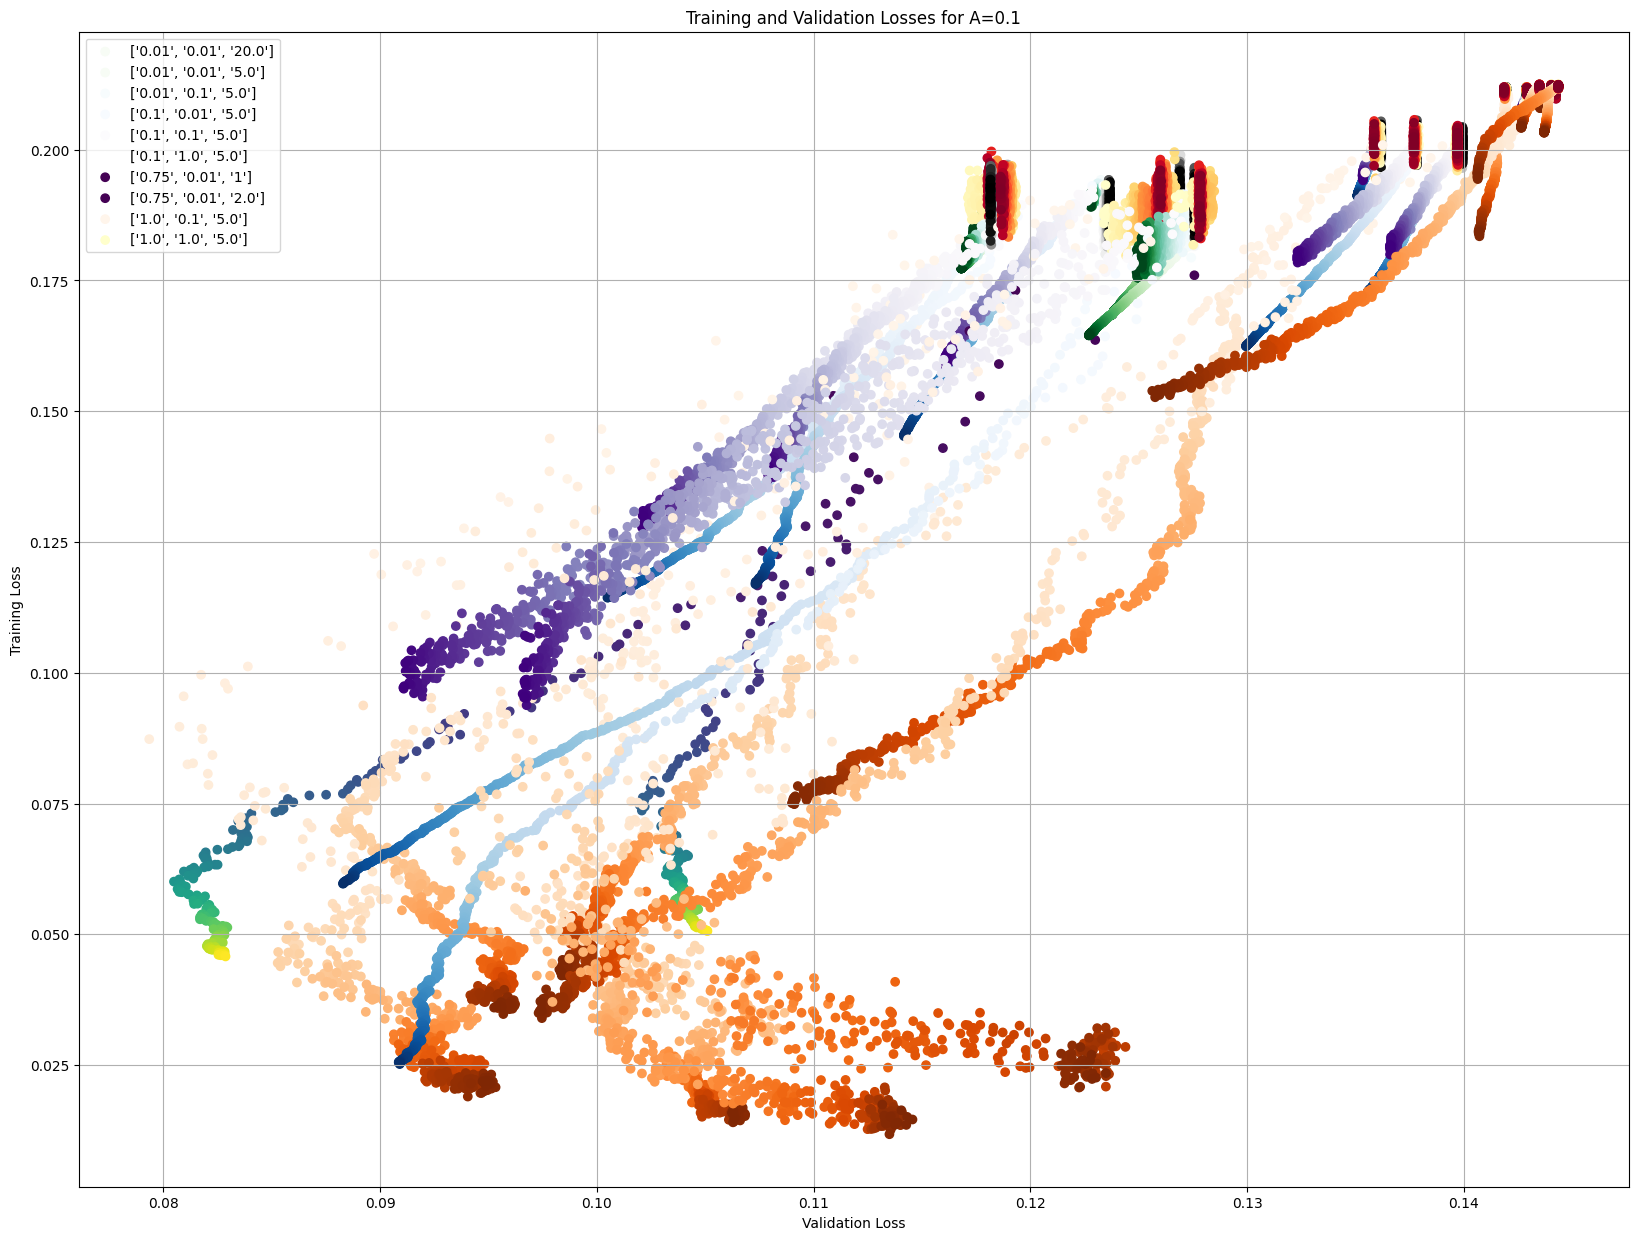

In [93]:
# Filter the models where optimizer_hyperparams_str[0] == '0.01' or '1.0'
filtered_models = [model_info for model_info in all_models_info]# if model_info['optimizer_hyperparams_str'][0] in ['0.01', '1.0']]

# Get unique values of optimizer_hyperparams_str
unique_values = [tuple(model_info['optimizer_hyperparams_str']) for model_info in filtered_models]

# Create a dictionary to map each unique combination to a color
color_map = {
    ('0.01', '0.01', '20.0'): 'Greens', 
    ('0.01', '0.01', '5.0'): 'Greens', 
    ('0.01','0.1','5.0'): 'BuGn',
    ('0.1','0.01','5.0'):  'Blues',
    ('0.1','0.1','5.0'):  'Purples',
    ('1.0','0.1','5.0'):  'Oranges',
    ('0.1','1.0','5.0'):  'Greys',
    ('1.0','1.0','5.0'):  'YlOrRd',  
    } 

fig = plt.figure(figsize=(20, 15))
added_labels = []
# Plot training and validation losses for each model in the filtered_models list
for i, model_info in enumerate(filtered_models):
    num_epochs = model_info['num_epochs']
    training_losses = model_info['training_losses']
    validation_losses = model_info['validation_losses']

    epochs = np.arange(1, num_epochs + 1)

    optimizer_param_value = tuple(model_info['optimizer_hyperparams_str'])
    cmap = color_map.get(optimizer_param_value)
    iterations_label = model_info['optimizer_hyperparams_str'] if model_info['optimizer_hyperparams_str'] not in added_labels else None
    plt.scatter(validation_losses, training_losses, c=epochs, cmap=cmap, label = iterations_label)
    added_labels.append(model_info['optimizer_hyperparams_str'])

plt.plot([0,1], [0,1], color='k', alpha=0.6)
plt.legend()
plt.xlabel('Validation Loss')
plt.ylabel('Training Loss')
plt.title('Training and Validation Losses for A=0.1')
plt.grid(True)